In [115]:
import QuantLib as ql
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Idea
- The idea of this exercise is to <b>price a callable bond</b> using the Quantlib Library


<br>

### 0. Setting up Evaluation Date

In [116]:
calc_date = ql.Date(16,8,2016)
ql.Settings.instance().evaluationDate = calc_date

<br>
<br>

### 1. Yield Curve Construction
- For simplicity, a <b>flat interest rate term structure</b> with yield curve at 3.5% is assumed

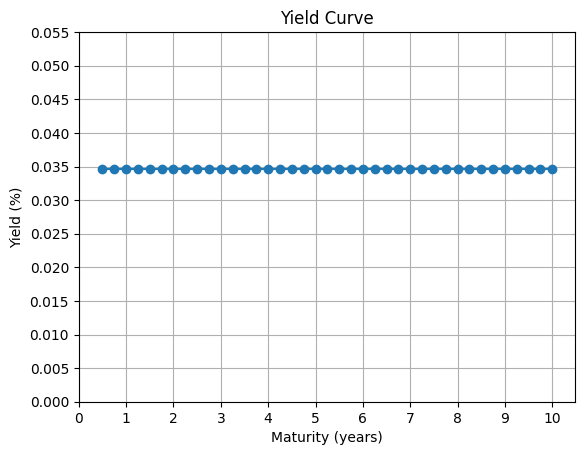

In [117]:
day_count = ql.ActualActual(ql.ActualActual.Bond)
rate = 0.035
ts = ql.FlatForward(calc_date, 
                    rate,
                    day_count, 
                    ql.Compounded,                      # Compounding method, (1+r)^t in this case
                    ql.Semiannual)                      # Compounding frequency
ts_handle = ql.YieldTermStructureHandle(ts)



maturities = np.arange(0.5, 10.1, 0.25)  # Maturities from 0.5 to 10 years
yields = []
for maturity in maturities:
    # Calculate the yield for each maturity
    maturity_date = calc_date + ql.Period(int(maturity * 365), ql.Days)
    yield_value = ts_handle.zeroRate(maturity_date, day_count, ql.Semiannual).rate()
    yields.append(yield_value)

# Plotting the yield curve
plt.plot(maturities, yields, marker='o')
plt.title('Yield Curve')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.grid()
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 0.06, 0.005))
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.show()

<br>
<br>

### 2. Setting up Call Schedule
- Setting up <b>call schedule</b> for the bond
- The bond is <b>callable every 3 months</b> with a <b>call price</b> of $100

In [121]:
callability_schedule = ql.CallabilitySchedule()
call_price = 100.0
call_date = ql.Date(15,ql.September,2016)
null_calendar = ql.NullCalendar()

for i in range(0,24):
    callability_price = ql.BondPrice(call_price, ql.BondPrice.Clean)             # An object to store bond price information
    callability_schedule.append(
        ql.Callability(callability_price,
                       ql.Callability.Call,
                       call_date))
    call_date = null_calendar.advance(call_date, 3, ql.Months)                    # Bond is callable every 3 months  

list(callability.date() for callability in callability_schedule)

[Date(15,9,2016),
 Date(15,12,2016),
 Date(15,3,2017),
 Date(15,6,2017),
 Date(15,9,2017),
 Date(15,12,2017),
 Date(15,3,2018),
 Date(15,6,2018),
 Date(15,9,2018),
 Date(15,12,2018),
 Date(15,3,2019),
 Date(15,6,2019),
 Date(15,9,2019),
 Date(15,12,2019),
 Date(15,3,2020),
 Date(15,6,2020),
 Date(15,9,2020),
 Date(15,12,2020),
 Date(15,3,2021),
 Date(15,6,2021),
 Date(15,9,2021),
 Date(15,12,2021),
 Date(15,3,2022),
 Date(15,6,2022)]

<br>
<br>

### 3. Setting up Payment Schedule
- Coupons are paid <b>quarterly</b>

In [124]:
issue_date = ql.Date(16,ql.September,2014)                     # bond issue date
maturity_date = ql.Date(15,ql.September,2022)                  # bond maturity date
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
tenor = ql.Period(ql.Quarterly)                                # quarterly payment
accrual_convention = ql.Unadjusted

schedule = ql.Schedule(issue_date, maturity_date, tenor,
                       calendar, accrual_convention,
                       accrual_convention,
                       ql.DateGeneration.Backward, False)

<br>
<br>

### 4. Creating CallableFixedRateBond in Quantlib
- Coupon rate is <b>2.5%</b>

In [110]:
settlement_days = 3
face_amount = 100
accrual_daycount = ql.ActualActual(ql.ActualActual.Bond)
coupon = 0.025

callable_bond = ql.CallableFixedRateBond(settlement_days, face_amount, schedule, 
                                         [coupon], accrual_daycount, ql.Following, 
                                         face_amount, issue_date, callability_schedule)

<br>
<br>

### 5. Valuing Callable Bond with Hull-White Model
- We would be using the <b>Hull-White model</b> to model interest rates
- <b>Speed of mean reversion</b> and <b>volatility</b> are specified for Hull-White Model

In [125]:
def value_bond(a, s, grid_points, bond):
    model = ql.HullWhite(ts_handle, a, s)
    engine = ql.TreeCallableFixedRateBondEngine(model, grid_points)
    bond.setPricingEngine(engine)
    return bond

mean_reversion_speed = 0.03
volatility = 0.12
callable_bond_price = value_bond(mean_reversion_speed, volatility, 40, callable_bond).cleanPrice()
print(f"Mean Reversion Speed: {mean_reversion_speed}")
print(f"Volatility: {volatility}")
print(f"Bond Price: {callable_bond_price}")

Mean Reversion Speed: 0.03
Volatility: 0.12
Bond Price: 68.31810243227723


<br>
<br>
As <b>volatility increases</b>, there is a <b>higher chance of the bond being called</b>. Hence, the lower bond price.

Text(0.5, 1.0, 'Callable Bond Price vs Volatility')

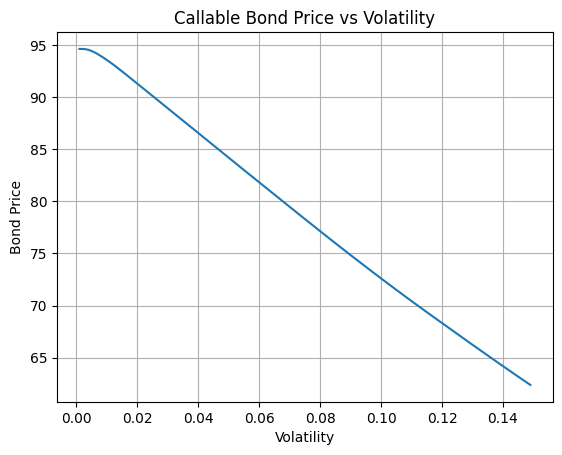

In [122]:
sigmas = np.arange(0.001, 0.15, 0.001)
prices = [value_bond(0.03, s, 40, callable_bond).cleanPrice() for s in sigmas]

plt.figure(1)
plt.grid()
plt.plot(sigmas, prices)
plt.xlabel("Volatility")
plt.ylabel("Bond Price")
plt.title("Callable Bond Price vs Volatility")